# **Лабораторная работа 3: «Перенос знаний с использованием PyTorch»**
Подключаем все необходимые библиотеки

In [17]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plot
import os
import time
from sklearn.metrics import f1_score

Зададим все необходимые параметры

In [18]:
# размер пачки
batchSize = 64
# скорость обучения
learningRate = 0.001
# количество эпох
epochCount = 15

Загружаем изображения из набора данных Garbage Classification

In [19]:
dataset = ImageFolder("/content/Garbage classification/Garbage classification", transform=torchvision.transforms.ToTensor())

#Разделяем датасет на тренировочную, валидационную и тестовую выборки в соотношении 70/15/15
trainDataset, validationDataset, testDataset = random_split(dataset, [1769, 379, 379])

Задаём функцию для вывода картинок с подписями

In [20]:
def showImgs(title, images):
    imgsCount = 6

    fig, axes = plot.subplots(imgsCount, imgsCount, figsize = (8,8))
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks=[], yticks=[])

    for i, axes in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0)
        axes.imshow(img)
        axes.set_title(dataset.classes[images[i][1]])
        plot.tight_layout()

Количество тренировочных данных: 1769
Количество валидационных данных: 379
Количество тестовых данных: 379


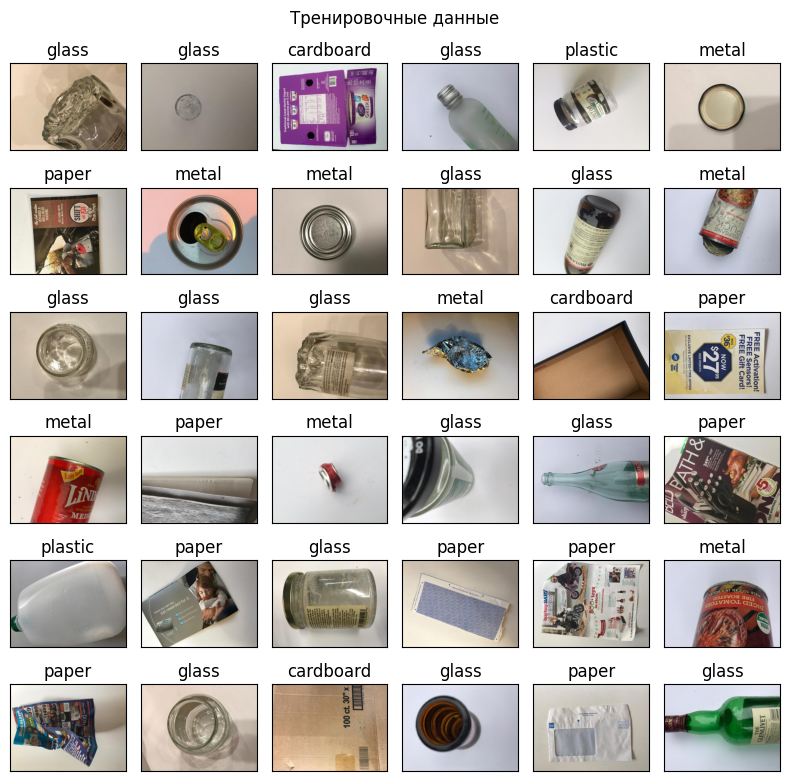

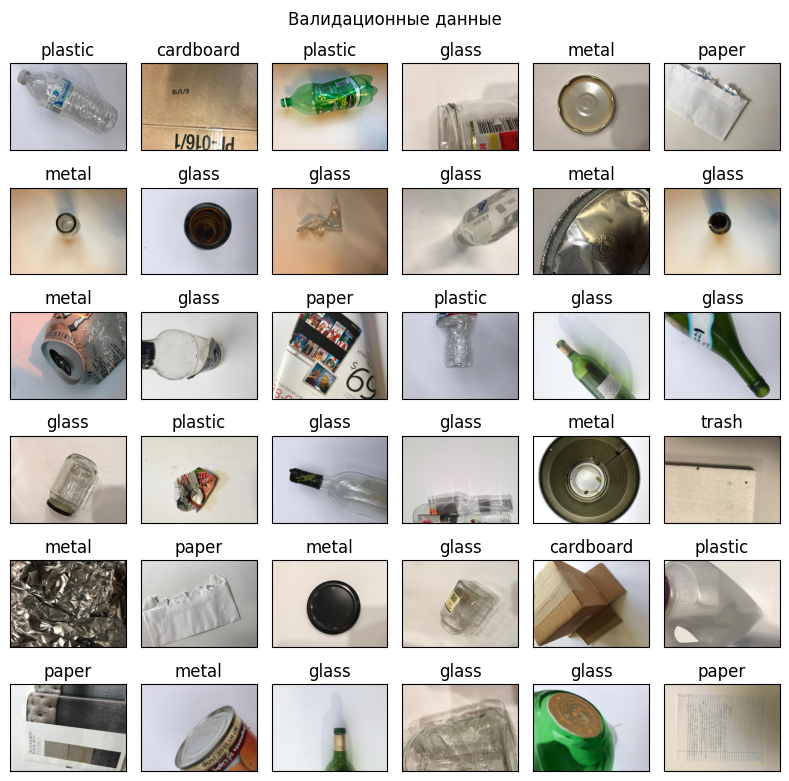

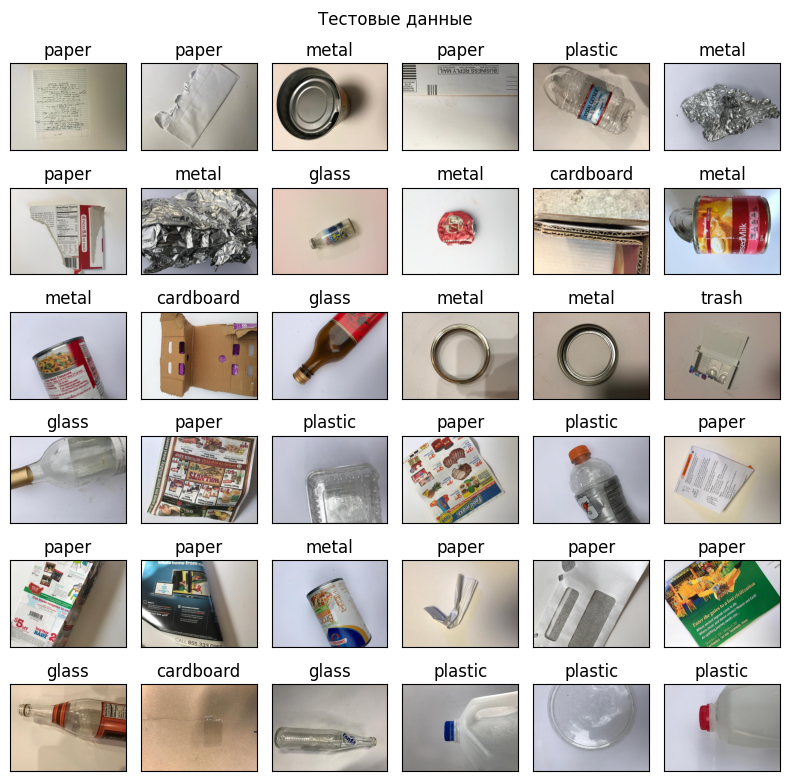

In [21]:
print('Количество тренировочных данных: {}'.format(len(trainDataset)))
print('Количество валидационных данных: {}'.format(len(validationDataset)))
print('Количество тестовых данных: {}'.format(len(testDataset)))

showImgs('Тренировочные данные', trainDataset)
showImgs('Валидационные данные', validationDataset)
showImgs('Тестовые данные', testDataset)

Разделим данные на пакеты

In [22]:
trainDataLoader = DataLoader(trainDataset, batchSize, shuffle = True)
validationDataLoader = DataLoader(validationDataset, batchSize)
testDataLoader = DataLoader(testDataset, batchSize)

В качестве архетектур выберем следующие:


*   ResNet
*   Efficientnet
*   Densenet
*   Shufflenet

И зададим по два вида модификаций для каждой из них



In [23]:
def firstModificationForResNet(model):
  # Замораживаем все параметры модели
  for params in model.parameters():
    params.requires_grad = False

  model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
  return model

def firstModificationForEfficientnet(model):
  # Замораживаем все параметры модели
  for params in model.parameters():
    params.requires_grad = False

  model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(dataset.classes))
  return model

def firstModificationForDensenet(model):
  # Замораживаем все параметры модели
  for params in model.parameters():
    params.requires_grad = False

  model.classifier = torch.nn.Linear(model.classifier.in_features, len(dataset.classes))
  return model

def firstModificationForVGG(model):
  # Замораживаем все параметры модели
  for params in model.parameters():
    params.requires_grad = False

  model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, len(dataset.classes))
  return model

In [24]:
def secondModificationForResNet(model):
  for params in model.parameters():
    params.requires_grad = False

  inputLayers = model.fc.in_features

  model.fc = torch.nn.Sequential(
        torch.nn.Linear(inputLayers, inputLayers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(inputLayers//2, len(dataset.classes)),
        )
  return model

def secondModificationForEfficientnet(model):
  for params in model.parameters():
    params.requires_grad = False

  inputLayers = model.classifier[1].in_features

  model.classifier[1] = torch.nn.Sequential(
        torch.nn.Linear(inputLayers, inputLayers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(inputLayers//2, len(dataset.classes)),
        )
  return model

def secondModificationForDensenet(model):
  for params in model.parameters():
    params.requires_grad = False

  inputLayers = model.classifier.in_features

  model.classifier = torch.nn.Sequential(
        torch.nn.Linear(inputLayers, inputLayers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(inputLayers//2, len(dataset.classes)),
        )
  return model

def secondModificationForVGG(model):
  for params in model.parameters():
    params.requires_grad = False

  inputLayers = model.classifier[6].in_features

  model.classifier[6] = torch.nn.Sequential(
        torch.nn.Linear(inputLayers, inputLayers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(inputLayers//2, len(dataset.classes)),
        )
  return model

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# в качестве функции ошибки выбирем кросс-энтропию
lossFunction = torch.nn.CrossEntropyLoss()

cuda:0


Зададим функцию для подсчёта Macro F1-score

In [26]:
def calculateF1(model, dataLoader):
  f1_list = []
  with torch.no_grad():
    for images, labels in dataLoader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        f1 = f1_score(labels.cpu(), preds.cpu(), average="macro")
        f1_list.append(f1)
  return sum(f1_list) / len(f1_list)

Тренеруем нейронку по эпохам с применением мини-пакетов

In [27]:
def train(modelTrain, data, validationDataLoader):
  # в качестве оптимизатора выберем наиболее часто используемый на практике Алгоритм Адама
  optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, modelTrain.parameters()), lr=learningRate)
  startTime = time.time()
  f1_list = []
  # Обучение по эпохам
  for epoch in range(epochCount):
    epochTimeStart = time.time()
    # Точность и потери всех пакетов эпохи
    lossEpoch = []
    # Проход по пакетам данных
    for i, (images, labels) in enumerate(data):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = modelTrain(images)
        loss = lossFunction(outputs, labels)
        lossEpoch.append(loss)

        loss.backward()
        optimizer.step()
    # Вывод информации
    print(epoch + 1, "эпоха: ")
    print("Обучение: ", "loss = {:.3f}".format(torch.stack(lossEpoch).mean()), ", время = {:.3f}".format(time.time() - epochTimeStart))

    #Проводим валидацию
    validationTimeStart = time.time()
    f1_all = []
    with torch.no_grad():
      for images, labels in validationDataLoader:
          images, labels = images.to(device), labels.to(device)
          outputs = modelTrain(images)
          _, preds = torch.max(outputs, 1)
          f1 = f1_score(labels.cpu(), preds.cpu(), average="macro")
          f1_all.append(f1)
    val_f1 = calculateF1(modelTrain, validationDataLoader)
    f1_list.append(val_f1)
    # Вывод информации
    print("Валидация: ", "loss = {:.3f}".format(torch.stack(lossEpoch).mean()), ", F1-score = {:.3f}".format(val_f1),
          ", время = {:.3f}".format(time.time() - validationTimeStart))

  print("общее время обучения: {:.3f}".format((time.time() - startTime) / 60), "минут")
  return f1_list

Зададим функцию для проведения эксперимента

In [28]:
def runExperiment(model):
  model = model.to(device)
  f1_list = train(model, trainDataLoader, validationDataLoader)
  plot.plot(range(epochCount), f1_list, marker="o")
  plot.xlabel("Epoch number")
  plot.xticks([i for i in range(epochCount)])
  plot.ylabel("F1-score")
  plot.grid()
  plot.show()

In [29]:
f1_test_table = []

model1 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model2 = torchvision.models.efficientnet_b0(weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT)
model3 = torchvision.models.densenet169(weights = torchvision.models.DenseNet169_Weights.DEFAULT)
model4 = torchvision.models.vgg16(weights = torchvision.models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.2MB/s]


In [30]:
model1_1 = firstModificationForResNet(model1)
model1_2 = secondModificationForResNet(model1)
model2_1 = firstModificationForEfficientnet(model2)
model2_2 = secondModificationForEfficientnet(model2)
model3_1 = firstModificationForDensenet(model3)
model3_2 = secondModificationForDensenet(model3)
model4_1 = firstModificationForVGG(model4)
model4_2 = secondModificationForVGG(model4)

1 эпоха: 
Обучение:  loss = 0.978 , время = 19.864
Валидация:  loss = 0.978 , F1-score = 0.731 , время = 11.895
2 эпоха: 
Обучение:  loss = 0.469 , время = 19.939
Валидация:  loss = 0.469 , F1-score = 0.830 , время = 12.659
3 эпоха: 
Обучение:  loss = 0.291 , время = 19.657
Валидация:  loss = 0.291 , F1-score = 0.849 , время = 12.067
4 эпоха: 
Обучение:  loss = 0.231 , время = 19.801
Валидация:  loss = 0.231 , F1-score = 0.865 , время = 11.932
5 эпоха: 
Обучение:  loss = 0.142 , время = 19.858
Валидация:  loss = 0.142 , F1-score = 0.857 , время = 11.956
6 эпоха: 
Обучение:  loss = 0.110 , время = 19.748
Валидация:  loss = 0.110 , F1-score = 0.881 , время = 11.813
7 эпоха: 
Обучение:  loss = 0.075 , время = 19.751
Валидация:  loss = 0.075 , F1-score = 0.873 , время = 11.792
8 эпоха: 
Обучение:  loss = 0.062 , время = 19.901
Валидация:  loss = 0.062 , F1-score = 0.903 , время = 11.820
9 эпоха: 
Обучение:  loss = 0.046 , время = 19.744
Валидация:  loss = 0.046 , F1-score = 0.877 , время =

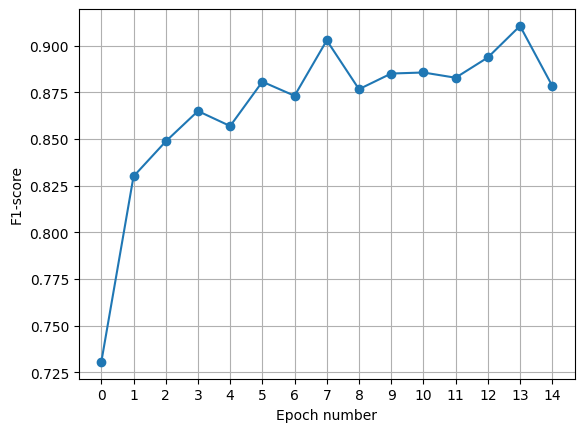

Тестирование:  f1 = 0.889


In [31]:
runExperiment(model1_1)
f1_test=calculateF1(model1_1, testDataLoader)
# Вывод информации
print("Тестирование: ", "f1 = {:.3f}".format(f1_test))
f1_test_table.append(f1_test)

1 эпоха: 
Обучение:  loss = 0.052 , время = 19.735
Валидация:  loss = 0.052 , F1-score = 0.873 , время = 11.671
2 эпоха: 
Обучение:  loss = 0.015 , время = 19.880
Валидация:  loss = 0.015 , F1-score = 0.880 , время = 12.038
3 эпоха: 
Обучение:  loss = 0.018 , время = 19.760
Валидация:  loss = 0.018 , F1-score = 0.867 , время = 11.846
4 эпоха: 
Обучение:  loss = 0.011 , время = 19.787
Валидация:  loss = 0.011 , F1-score = 0.886 , время = 11.715
5 эпоха: 
Обучение:  loss = 0.008 , время = 19.805
Валидация:  loss = 0.008 , F1-score = 0.915 , время = 11.665
6 эпоха: 
Обучение:  loss = 0.020 , время = 19.932
Валидация:  loss = 0.020 , F1-score = 0.902 , время = 11.834
7 эпоха: 
Обучение:  loss = 0.051 , время = 19.811
Валидация:  loss = 0.051 , F1-score = 0.884 , время = 11.967
8 эпоха: 
Обучение:  loss = 0.031 , время = 19.817
Валидация:  loss = 0.031 , F1-score = 0.857 , время = 11.646
9 эпоха: 
Обучение:  loss = 0.015 , время = 19.847
Валидация:  loss = 0.015 , F1-score = 0.852 , время =

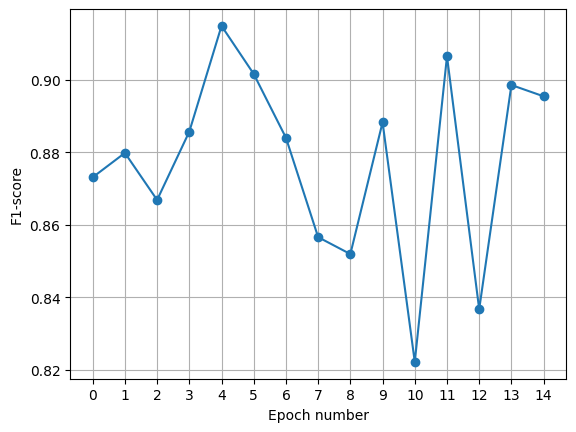

Тестирование:  f1 = 0.900


In [32]:
runExperiment(model1_2)
f1_test=calculateF1(model1_2, testDataLoader)
# Вывод информации
print("Тестирование: ", "f1 = {:.3f}".format(f1_test))
f1_test_table.append(f1_test)

1 эпоха: 
Обучение:  loss = 0.998 , время = 11.207
Валидация:  loss = 0.998 , F1-score = 0.669 , время = 6.959
2 эпоха: 
Обучение:  loss = 0.519 , время = 10.073
Валидация:  loss = 0.519 , F1-score = 0.737 , время = 7.221
3 эпоха: 
Обучение:  loss = 0.370 , время = 9.788
Валидация:  loss = 0.370 , F1-score = 0.796 , время = 7.468
4 эпоха: 
Обучение:  loss = 0.324 , время = 9.618
Валидация:  loss = 0.324 , F1-score = 0.771 , время = 7.318
5 эпоха: 
Обучение:  loss = 0.302 , время = 10.021
Валидация:  loss = 0.302 , F1-score = 0.808 , время = 6.936
6 эпоха: 
Обучение:  loss = 0.233 , время = 10.200
Валидация:  loss = 0.233 , F1-score = 0.793 , время = 7.062
7 эпоха: 
Обучение:  loss = 0.191 , время = 9.845
Валидация:  loss = 0.191 , F1-score = 0.829 , время = 7.571
8 эпоха: 
Обучение:  loss = 0.165 , время = 9.315
Валидация:  loss = 0.165 , F1-score = 0.835 , время = 7.404
9 эпоха: 
Обучение:  loss = 0.145 , время = 10.043
Валидация:  loss = 0.145 , F1-score = 0.826 , время = 6.889
10 эп

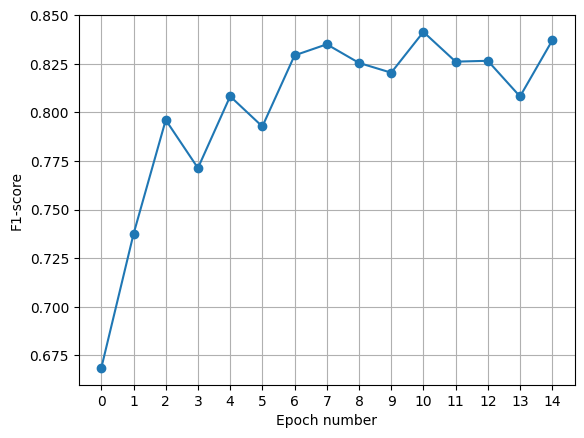

Тестирование:  f1 = 0.853


In [33]:
runExperiment(model2_1)
f1_test=calculateF1(model2_1, testDataLoader)
# Вывод информации
print("Тестирование: ", "f1 = {:.3f}".format(f1_test))
f1_test_table.append(f1_test)

1 эпоха: 
Обучение:  loss = 0.082 , время = 9.505
Валидация:  loss = 0.082 , F1-score = 0.827 , время = 7.391
2 эпоха: 
Обучение:  loss = 0.071 , время = 10.164
Валидация:  loss = 0.071 , F1-score = 0.839 , время = 6.872
3 эпоха: 
Обучение:  loss = 0.075 , время = 10.136
Валидация:  loss = 0.075 , F1-score = 0.822 , время = 7.286
4 эпоха: 
Обучение:  loss = 0.069 , время = 9.767
Валидация:  loss = 0.069 , F1-score = 0.813 , время = 7.541
5 эпоха: 
Обучение:  loss = 0.060 , время = 9.386
Валидация:  loss = 0.060 , F1-score = 0.802 , время = 7.431
6 эпоха: 
Обучение:  loss = 0.067 , время = 10.058
Валидация:  loss = 0.067 , F1-score = 0.802 , время = 6.971
7 эпоха: 
Обучение:  loss = 0.064 , время = 10.142
Валидация:  loss = 0.064 , F1-score = 0.831 , время = 7.079
8 эпоха: 
Обучение:  loss = 0.055 , время = 9.891
Валидация:  loss = 0.055 , F1-score = 0.808 , время = 7.612
9 эпоха: 
Обучение:  loss = 0.045 , время = 9.290
Валидация:  loss = 0.045 , F1-score = 0.837 , время = 7.582
10 эпо

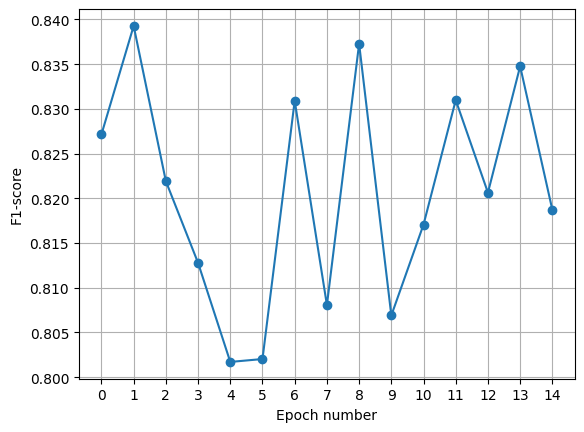

Тестирование:  f1 = 0.860


In [34]:
runExperiment(model2_2)
f1_test=calculateF1(model2_2, testDataLoader)
# Вывод информации
print("Тестирование: ", "f1 = {:.3f}".format(f1_test))
f1_test_table.append(f1_test)

1 эпоха: 
Обучение:  loss = 1.113 , время = 25.953
Валидация:  loss = 1.113 , F1-score = 0.618 , время = 14.419
2 эпоха: 
Обучение:  loss = 0.554 , время = 25.890
Валидация:  loss = 0.554 , F1-score = 0.776 , время = 14.485
3 эпоха: 
Обучение:  loss = 0.387 , время = 25.903
Валидация:  loss = 0.387 , F1-score = 0.812 , время = 14.419
4 эпоха: 
Обучение:  loss = 0.314 , время = 25.807
Валидация:  loss = 0.314 , F1-score = 0.848 , время = 14.455
5 эпоха: 
Обучение:  loss = 0.292 , время = 25.816
Валидация:  loss = 0.292 , F1-score = 0.777 , время = 14.391
6 эпоха: 
Обучение:  loss = 0.258 , время = 25.802
Валидация:  loss = 0.258 , F1-score = 0.843 , время = 14.425
7 эпоха: 
Обучение:  loss = 0.227 , время = 25.828
Валидация:  loss = 0.227 , F1-score = 0.844 , время = 14.324
8 эпоха: 
Обучение:  loss = 0.253 , время = 25.835
Валидация:  loss = 0.253 , F1-score = 0.779 , время = 14.437
9 эпоха: 
Обучение:  loss = 0.261 , время = 25.826
Валидация:  loss = 0.261 , F1-score = 0.856 , время =

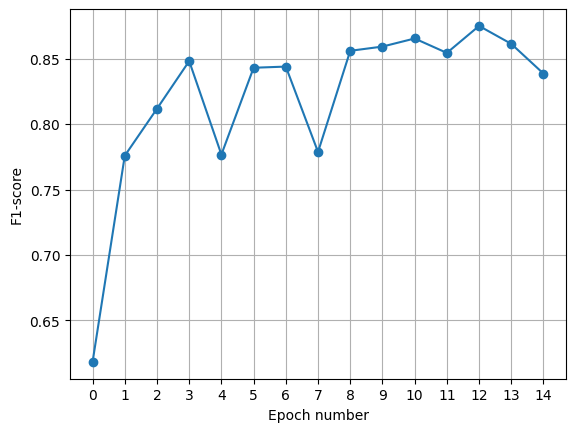

Тестирование:  f1 = 0.863


In [35]:
runExperiment(model3_1)
f1_test=calculateF1(model3_1, testDataLoader)
# Вывод информации
print("Тестирование: ", "f1 = {:.3f}".format(f1_test))
f1_test_table.append(f1_test)

1 эпоха: 
Обучение:  loss = 0.163 , время = 25.883
Валидация:  loss = 0.163 , F1-score = 0.872 , время = 14.410
2 эпоха: 
Обучение:  loss = 0.086 , время = 25.892
Валидация:  loss = 0.086 , F1-score = 0.861 , время = 14.294
3 эпоха: 
Обучение:  loss = 0.078 , время = 25.843
Валидация:  loss = 0.078 , F1-score = 0.867 , время = 14.367
4 эпоха: 
Обучение:  loss = 0.092 , время = 25.841
Валидация:  loss = 0.092 , F1-score = 0.828 , время = 14.336
5 эпоха: 
Обучение:  loss = 0.079 , время = 25.783
Валидация:  loss = 0.079 , F1-score = 0.869 , время = 14.375
6 эпоха: 
Обучение:  loss = 0.062 , время = 25.812
Валидация:  loss = 0.062 , F1-score = 0.843 , время = 14.395
7 эпоха: 
Обучение:  loss = 0.059 , время = 25.785
Валидация:  loss = 0.059 , F1-score = 0.877 , время = 14.328
8 эпоха: 
Обучение:  loss = 0.044 , время = 25.812
Валидация:  loss = 0.044 , F1-score = 0.864 , время = 14.318
9 эпоха: 
Обучение:  loss = 0.056 , время = 25.798
Валидация:  loss = 0.056 , F1-score = 0.870 , время =

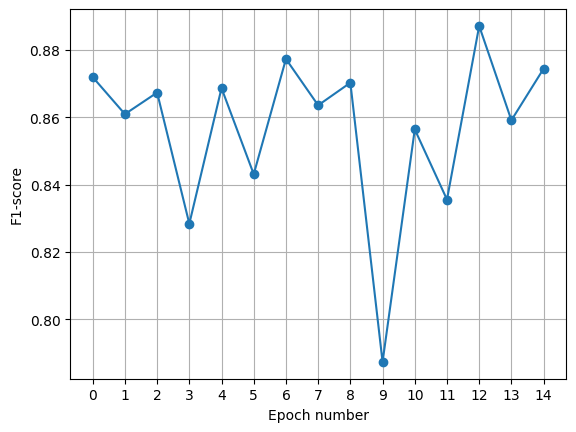

Тестирование:  f1 = 0.894


In [36]:
runExperiment(model3_2)
f1_test=calculateF1(model3_2, testDataLoader)
# Вывод информации
print("Тестирование: ", "f1 = {:.3f}".format(f1_test))
f1_test_table.append(f1_test)

1 эпоха: 
Обучение:  loss = 1.067 , время = 32.623
Валидация:  loss = 1.067 , F1-score = 0.614 , время = 17.063
2 эпоха: 
Обучение:  loss = 0.724 , время = 31.854
Валидация:  loss = 0.724 , F1-score = 0.626 , время = 16.909
3 эпоха: 
Обучение:  loss = 0.615 , время = 31.885
Валидация:  loss = 0.615 , F1-score = 0.669 , время = 16.972
4 эпоха: 
Обучение:  loss = 0.550 , время = 32.000
Валидация:  loss = 0.550 , F1-score = 0.659 , время = 16.998
5 эпоха: 
Обучение:  loss = 0.506 , время = 31.885
Валидация:  loss = 0.506 , F1-score = 0.690 , время = 16.924
6 эпоха: 
Обучение:  loss = 0.453 , время = 31.960
Валидация:  loss = 0.453 , F1-score = 0.705 , время = 16.961
7 эпоха: 
Обучение:  loss = 0.398 , время = 31.865
Валидация:  loss = 0.398 , F1-score = 0.695 , время = 17.246
8 эпоха: 
Обучение:  loss = 0.376 , время = 32.009
Валидация:  loss = 0.376 , F1-score = 0.722 , время = 16.822
9 эпоха: 
Обучение:  loss = 0.331 , время = 31.895
Валидация:  loss = 0.331 , F1-score = 0.720 , время =

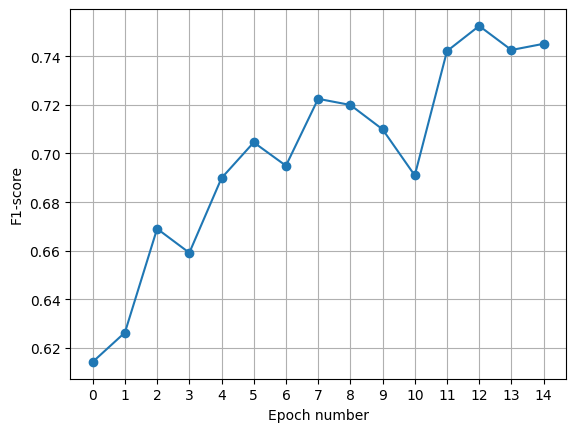

Тестирование:  f1 = 0.714


In [37]:
runExperiment(model4_1)
f1_test=calculateF1(model4_1, testDataLoader)
# Вывод информации
print("Тестирование: ", "f1 = {:.3f}".format(f1_test))
f1_test_table.append(f1_test)

1 эпоха: 
Обучение:  loss = 0.279 , время = 31.894
Валидация:  loss = 0.279 , F1-score = 0.684 , время = 17.033
2 эпоха: 
Обучение:  loss = 0.212 , время = 31.858
Валидация:  loss = 0.212 , F1-score = 0.724 , время = 16.869
3 эпоха: 
Обучение:  loss = 0.168 , время = 31.861
Валидация:  loss = 0.168 , F1-score = 0.778 , время = 16.896
4 эпоха: 
Обучение:  loss = 0.211 , время = 31.873
Валидация:  loss = 0.211 , F1-score = 0.741 , время = 16.777
5 эпоха: 
Обучение:  loss = 0.175 , время = 32.028
Валидация:  loss = 0.175 , F1-score = 0.715 , время = 17.001
6 эпоха: 
Обучение:  loss = 0.175 , время = 31.856
Валидация:  loss = 0.175 , F1-score = 0.753 , время = 16.914
7 эпоха: 
Обучение:  loss = 0.137 , время = 31.955
Валидация:  loss = 0.137 , F1-score = 0.751 , время = 16.831
8 эпоха: 
Обучение:  loss = 0.142 , время = 31.895
Валидация:  loss = 0.142 , F1-score = 0.763 , время = 16.886
9 эпоха: 
Обучение:  loss = 0.168 , время = 31.945
Валидация:  loss = 0.168 , F1-score = 0.754 , время =

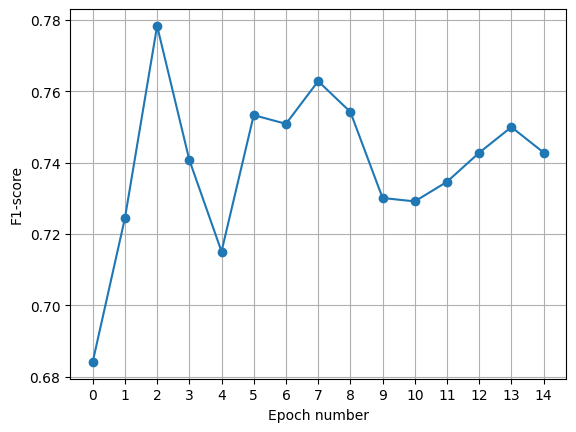

Тестирование:  f1 = 0.747


In [38]:
runExperiment(model4_2)
f1_test=calculateF1(model4_2, testDataLoader)
# Вывод информации
print("Тестирование: ", "f1 = {:.3f}".format(f1_test))
f1_test_table.append(f1_test)

Построим сравнительную столбчатую диаграмму точностей

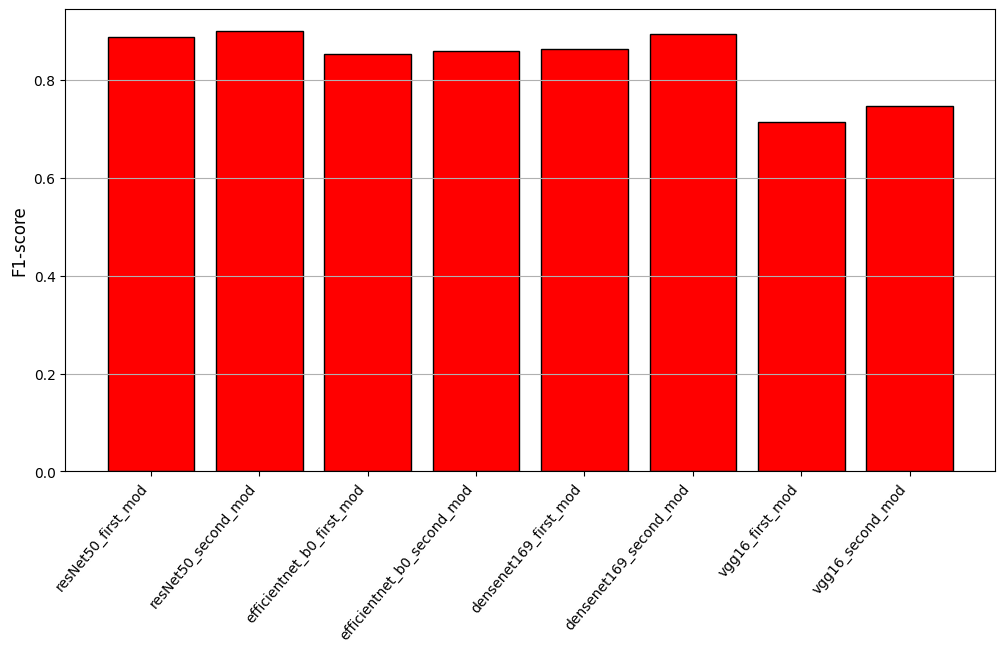

In [40]:
name_networks = [
    'resNet50_first_mod',
    'resNet50_second_mod',
    'efficientnet_b0_first_mod',
    'efficientnet_b0_second_mod',
    'densenet169_first_mod',
    'densenet169_second_mod',
    'vgg16_first_mod',
    'vgg16_second_mod']

plot.figure(figsize=(12, 6))
bars = plot.bar(name_networks, f1_test_table, color = 'red', edgecolor = 'black')
plot.ylabel('F1-score', fontsize = 12)
plot.xticks(rotation = 50, ha = 'right')
plot.grid(axis='y')
plot.show()